<a href="https://colab.research.google.com/github/sjung-stat/Customer-Support-Chat-Intent-Classification/blob/main/Model%20Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before building a text classification model using BERT, we need to preprocess the dataset. First of all, we do one-hot encoding on our target variable. And after that, we use one of the companions of BERT models which is designed to work alongside BERT models, and its purpose is to transform unprocessed textual inputs into the appropriate input format required by BERT. More details can be found below.

In [1]:
# Import necessary libraries

from google.colab import drive
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Load the preprocessed training and testing data
drive.mount('/content/drive')

with open('/content/drive/MyDrive/df_training_complete.pkl', 'rb') as f:   # Load `df_training_complete` from Google Drive
    df_training_complete = pickle.load(f)

with open('/content/drive/MyDrive/df_testing_copy.pkl', 'rb') as f:   # Load `df_testing_copy` from Google Drive
    df_testing_complete = pickle.load(f)

Mounted at /content/drive


# Preprocessing

## One Hot Encoding

In [3]:
# Split training and validation sets and reformat testing set. 
trainfeatures, validfeatures, trainlabels, validlabels = train_test_split(df_training_complete['text'],df_training_complete['category'], stratify=df_training_complete['category'], test_size=0.2)

testfeatures=df_testing_complete.copy()
testlabels=testfeatures.pop("category")
trainlabels_original= trainlabels.values


# One-Hot-Encoding of class-labels
binarizer=LabelBinarizer()  

trainlabels=binarizer.fit_transform(trainlabels.values)
validlabels=binarizer.transform(validlabels.values)
testlabels=binarizer.transform(testlabels.values)
trainfeatures = pd.DataFrame(trainfeatures)
validfeatures = pd.DataFrame(validfeatures)

In [4]:
print("Total number of training examples: ", trainfeatures.shape[0])
print("Total number of validation examples: ", validfeatures.shape[0])
print("Total number of testing examples: ", testfeatures.shape[0])

Total number of training examples:  12733
Total number of validation examples:  3184
Total number of testing examples:  3080


In [5]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 27.2 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt



---



# Model Building

For this intent classification project, we use BERT which is a pretrained language model. BERT is useful for intent classification because it is pre-trained on a large corpus of text data, allowing it to understand the nuances of natural language. Additionally, BERT uses a bidirectional approach, which means it can analyze a text input in both directions, allowing it to better understand the context and meaning of the input. By using BERT as a pre-processing step, you can improve the accuracy and efficiency of your intent classification model.

### Model 1

In [ ]:
# Note that the following preprocessing model cannot take pandas dataframe as input
# Need to convert the input data (text) into list
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") # The text data we will be working with will undergo preprocessing using a TensorFlow model.
                                                                                              # As this preprocessor is a TensorFlow model, it can be easily integrated directly into your own model.
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [ ]:
# Define input layer
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed = bert_preprocess(input_text)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert = bert_model(text_preprocessed)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output = output_bert['sequence_output']

# Apply average pooling over sequence output
avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

# Concatenate max pooled output and pooled output
concatenated_avg_pooling = tf.keras.layers.Concatenate()([avg_pooling, output_bert['pooled_output']])

# Apply dense layers to concatenated output
dense_1_avg_pooling = tf.keras.layers.Dense(512, activation='relu')(concatenated_avg_pooling)
dense_2_avg_pooling = tf.keras.layers.Dense(256, activation='relu')(dense_1_avg_pooling)
dense_3_avg_pooling = tf.keras.layers.Dense(128, activation='relu')(dense_2_avg_pooling)
dense_4_avg_pooling = tf.keras.layers.Dropout(0.1)(dense_3_avg_pooling)

# Define output layer
output_avg_pooling = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_4_avg_pooling)

# Define the model
model_avg_pooling = tf.keras.Model(inputs=input_text, outputs=output_avg_pooling)

# Freeze the BERT layers
bert_model.trainable = False  # sets the BERT model's trainable attribute to False, which freezes the weights of the BERT layers. 
                              # This means that during training, the weights of the BERT layers will not be updated. 
                              # Freezing the BERT layers can be beneficial when the dataset used to fine-tune BERT is small or when the task-specific layers have not converged yet. 
                              # Freezing the BERT layers allows the model to focus on learning the task-specific layers without overfitting to the small dataset or disrupting the already learned BERT weights.

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_avg_pooling.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [ ]:
history = model_avg_pooling.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
398/398 [==============================] - 86s 201ms/step - loss: 2.0331 - accuracy: 0.3683 - val_loss: 1.5259 - val_accuracy: 0.5355
Epoch 2/30
398/398 [==============================] - 79s 198ms/step - loss: 1.3135 - accuracy: 0.5941 - val_loss: 1.1253 - val_accuracy: 0.6636
Epoch 3/30
398/398 [==============================] - 78s 195ms/step - loss: 1.0502 - accuracy: 0.6715 - val_loss: 0.9479 - val_accuracy: 0.7249
Epoch 4/30
398/398 [==============================] - 78s 197ms/step - loss: 0.9031 - accuracy: 0.7177 - val_loss: 0.8546 - val_accuracy: 0.7437
Epoch 5/30
398/398 [==============================] - 78s 195ms/step - loss: 0.8081 - accuracy: 0.7443 - val_loss: 0.7900 - val_accuracy: 0.7579
Epoch 6/30
398/398 [==============================] - 79s 199ms/step - loss: 0.7332 - accuracy: 0.7707 - val_loss: 0.7433 - val_accuracy: 0.7692
Epoch 7/30
398/398 [==============================] - 83s 209ms/step - loss: 0.6840 - accuracy: 0.7839 - val_loss: 0.6987 - val_ac

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 2

In [ ]:
bert_preprocess_v2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model_v2 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [ ]:
# Define input layer
input_text_v2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed_v2 = bert_preprocess_v2(input_text_v2)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert_v2 = bert_model_v2(text_preprocessed_v2)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output_v2 = output_bert_v2['sequence_output']

# Apply max pooling over sequence output
max_pooling_v2 = tf.keras.layers.GlobalMaxPooling1D()(sequence_output_v2)

# Apply average pooling over sequence output
avg_pooling_v2 = tf.keras.layers.GlobalAveragePooling1D()(sequence_output_v2)

# Concatenate max pooled output and pooled output
concatenated_v2 = tf.keras.layers.Concatenate()([max_pooling_v2, avg_pooling_v2, output_bert_v2['pooled_output']])

# Apply dense layers to concatenated output
dense_1_v2 = tf.keras.layers.Dense(512, activation='relu')(concatenated_v2)
dense_2_v2 = tf.keras.layers.Dense(256, activation='relu')(dense_1_v2)
dense_3_v2 = tf.keras.layers.Dense(128, activation='relu')(dense_2_v2)
dense_4_v2 = tf.keras.layers.Dropout(0.1)(dense_3_v2)

# Define output layer
output_v2 = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_4_v2)

# Define the model
model_max_avg_pooling = tf.keras.Model(inputs=input_text_v2, outputs=output_v2)

# Freeze the BERT layers
bert_model_v2.trainable = False

# Compile the model
optimizer_v2 = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_max_avg_pooling.compile(optimizer=optimizer_v2, loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [ ]:
history_max_avg_pooling = model_max_avg_pooling.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
398/398 [==============================] - 100s 225ms/step - loss: 1.9592 - accuracy: 0.3784 - val_loss: 1.4508 - val_accuracy: 0.5628
Epoch 2/30
398/398 [==============================] - 86s 217ms/step - loss: 1.2809 - accuracy: 0.5976 - val_loss: 1.0911 - val_accuracy: 0.6731
Epoch 3/30
398/398 [==============================] - 81s 205ms/step - loss: 1.0375 - accuracy: 0.6771 - val_loss: 0.9266 - val_accuracy: 0.7192
Epoch 4/30
398/398 [==============================] - 80s 201ms/step - loss: 0.8895 - accuracy: 0.7194 - val_loss: 0.8252 - val_accuracy: 0.7509
Epoch 5/30
398/398 [==============================] - 81s 204ms/step - loss: 0.7961 - accuracy: 0.7506 - val_loss: 0.7543 - val_accuracy: 0.7701
Epoch 6/30
398/398 [==============================] - 85s 215ms/step - loss: 0.7169 - accuracy: 0.7753 - val_loss: 0.6989 - val_accuracy: 0.7855
Epoch 7/30
398/398 [==============================] - 85s 214ms/step - loss: 0.6585 - accuracy: 0.7920 - val_loss: 0.6558 - val_a

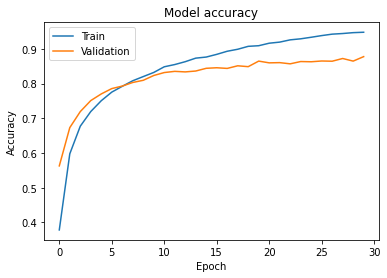

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_max_avg_pooling.history['accuracy'])
plt.plot(history_max_avg_pooling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 3 


In [ ]:
# consider 'early stopping'
# consider 'another dropout
# consider taking into account the weights of the classes

In [ ]:
bert_preprocess_v3 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model_v3 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [ ]:
# Define input layer
input_text_v3 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed_v3 = bert_preprocess_v2(input_text_v3)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert_v3 = bert_model_v3(text_preprocessed_v3)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output_v3 = output_bert_v3['sequence_output']

# Apply max pooling over sequence output
max_pooling_v3 = tf.keras.layers.GlobalMaxPooling1D()(sequence_output_v3)

# Apply average pooling over sequence output
avg_pooling_v3 = tf.keras.layers.GlobalAveragePooling1D()(sequence_output_v3)

# Concatenate max pooled output and pooled output
concatenated_v3 = tf.keras.layers.Concatenate()([max_pooling_v3, avg_pooling_v3, output_bert_v3['pooled_output']])

# Apply dense layers to concatenated output
dense_1_v3 = tf.keras.layers.Dense(512, activation='relu')(concatenated_v3)
dense_2_v3 = tf.keras.layers.Dense(256, activation='relu')(dense_1_v3)
dense_3_v3 = tf.keras.layers.Dropout(0.1)(dense_2_v3)
dense_4_v3 = tf.keras.layers.Dense(128, activation='relu')(dense_3_v3)
dense_5_v3 = tf.keras.layers.Dropout(0.1)(dense_4_v3)

# Define output layer
output_v3 = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_5_v3)

# Define the model
model_max_avg_pooling_v3 = tf.keras.Model(inputs=input_text_v3, outputs=output_v3)

# Freeze the BERT layers
bert_model_v3.trainable = False

# Compile the model
optimizer_v3 = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_max_avg_pooling_v3.compile(optimizer=optimizer_v3, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [ ]:
history_max_avg_pooling_v3 = model_max_avg_pooling_v3.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
398/398 [==============================] - 92s 211ms/step - loss: 2.0549 - accuracy: 0.3404 - val_loss: 1.5031 - val_accuracy: 0.5503
Epoch 2/30
398/398 [==============================] - 84s 210ms/step - loss: 1.3705 - accuracy: 0.5633 - val_loss: 1.1243 - val_accuracy: 0.6476
Epoch 3/30
398/398 [==============================] - 85s 214ms/step - loss: 1.1046 - accuracy: 0.6493 - val_loss: 0.9463 - val_accuracy: 0.7082
Epoch 4/30
398/398 [==============================] - 79s 199ms/step - loss: 0.9454 - accuracy: 0.7001 - val_loss: 0.8389 - val_accuracy: 0.7321
Epoch 5/30
398/398 [==============================] - 79s 200ms/step - loss: 0.8469 - accuracy: 0.7312 - val_loss: 0.7608 - val_accuracy: 0.7594
Epoch 6/30
398/398 [==============================] - 83s 208ms/step - loss: 0.7698 - accuracy: 0.7572 - val_loss: 0.6999 - val_accuracy: 0.7783
Epoch 7/30
398/398 [==============================] - 79s 199ms/step - loss: 0.7116 - accuracy: 0.7741 - val_loss: 0.6635 - val_ac

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_max_avg_pooling_v3.history['accuracy'])
plt.plot(history_max_avg_pooling_v3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 4: early stopping = 3

In [ ]:
# Early stopping

In [7]:
bert_preprocess_v4 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model_v4 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [8]:
# Define input layer
input_text_v4 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed_v4 = bert_preprocess_v4(input_text_v4)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert_v4 = bert_model_v4(text_preprocessed_v4)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output_v4 = output_bert_v4['sequence_output']

# Apply max pooling over sequence output
max_pooling_v4 = tf.keras.layers.GlobalMaxPooling1D()(sequence_output_v4)

# Apply average pooling over sequence output
avg_pooling_v4 = tf.keras.layers.GlobalAveragePooling1D()(sequence_output_v4)

# Concatenate max pooled output and pooled output
concatenated_v4 = tf.keras.layers.Concatenate()([max_pooling_v4, avg_pooling_v4, output_bert_v4['pooled_output']])

# Apply dense layers to concatenated output
dense_1_v4 = tf.keras.layers.Dense(512, activation='relu')(concatenated_v4)
dense_2_v4 = tf.keras.layers.Dense(256, activation='relu')(dense_1_v4)
dense_3_v4 = tf.keras.layers.Dropout(0.1)(dense_2_v4)
dense_4_v4 = tf.keras.layers.Dense(128, activation='relu')(dense_3_v4)
dense_5_v4 = tf.keras.layers.Dropout(0.1)(dense_4_v4)

# Define output layer
output_v4 = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_5_v4)

# Define the model
model_max_avg_pooling_v4 = tf.keras.Model(inputs=input_text_v4, outputs=output_v4)

# Freeze the BERT layers
bert_model_v4.trainable = False

# Compile the model
optimizer_v4 = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_max_avg_pooling_v4.compile(optimizer=optimizer_v4, loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if validation loss does not improve for 3 epochs
    restore_best_weights=True   # Restore the weights of the best epoch
)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [11]:
history_max_avg_pooling_v4 = model_max_avg_pooling_v4.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[earlystop_callback])

Epoch 1/30
398/398 [==============================] - 93s 203ms/step - loss: 2.0620 - accuracy: 0.3441 - val_loss: 1.5780 - val_accuracy: 0.5188
Epoch 2/30
398/398 [==============================] - 76s 192ms/step - loss: 1.3926 - accuracy: 0.5607 - val_loss: 1.1754 - val_accuracy: 0.6410
Epoch 3/30
398/398 [==============================] - 76s 192ms/step - loss: 1.1229 - accuracy: 0.6451 - val_loss: 1.0163 - val_accuracy: 0.6866
Epoch 4/30
398/398 [==============================] - 77s 192ms/step - loss: 0.9623 - accuracy: 0.6939 - val_loss: 0.9044 - val_accuracy: 0.7195
Epoch 5/30
398/398 [==============================] - 77s 193ms/step - loss: 0.8579 - accuracy: 0.7270 - val_loss: 0.8255 - val_accuracy: 0.7465
Epoch 6/30
398/398 [==============================] - 82s 206ms/step - loss: 0.7772 - accuracy: 0.7567 - val_loss: 0.7919 - val_accuracy: 0.7553
Epoch 7/30
398/398 [==============================] - 77s 193ms/step - loss: 0.7180 - accuracy: 0.7751 - val_loss: 0.7485 - val_ac

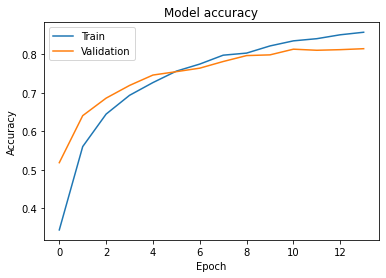

In [12]:
# Plot training & validation accuracy values
plt.plot(history_max_avg_pooling_v4.history['accuracy'])
plt.plot(history_max_avg_pooling_v4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 4-2: Early stopping = 5

In [13]:
bert_preprocess_v5 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model_v5 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [14]:
# Define input layer
input_text_v5 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed_v5 = bert_preprocess_v5(input_text_v5)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert_v5 = bert_model_v5(text_preprocessed_v5)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output_v5 = output_bert_v5['sequence_output']

# Apply max pooling over sequence output
max_pooling_v5 = tf.keras.layers.GlobalMaxPooling1D()(sequence_output_v5)

# Apply average pooling over sequence output
avg_pooling_v5 = tf.keras.layers.GlobalAveragePooling1D()(sequence_output_v5)

# Concatenate max pooled output and pooled output
concatenated_v5 = tf.keras.layers.Concatenate()([max_pooling_v5, avg_pooling_v5, output_bert_v5['pooled_output']])

# Apply dense layers to concatenated output
dense_1_v5 = tf.keras.layers.Dense(512, activation='relu')(concatenated_v5)
dense_2_v5 = tf.keras.layers.Dense(256, activation='relu')(dense_1_v5)
dense_3_v5 = tf.keras.layers.Dropout(0.1)(dense_2_v5)
dense_4_v5 = tf.keras.layers.Dense(128, activation='relu')(dense_3_v5)
dense_5_v5 = tf.keras.layers.Dropout(0.1)(dense_4_v5)

# Define output layer
output_v5 = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_5_v5)

# Define the model
model_max_avg_pooling_v5 = tf.keras.Model(inputs=input_text_v5, outputs=output_v5)

# Freeze the BERT layers
bert_model_v5.trainable = False

# Compile the model
optimizer_v5 = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_max_avg_pooling_v5.compile(optimizer=optimizer_v5, loss='categorical_crossentropy', metrics=['accuracy'])




In [15]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if validation loss does not improve for 5 epochs
    restore_best_weights=True   # Restore the weights of the best epoch
)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [17]:
history_max_avg_pooling_v5 = model_max_avg_pooling_v5.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[earlystop_callback])

Epoch 1/30
398/398 [==============================] - 86s 195ms/step - loss: 2.0559 - accuracy: 0.3327 - val_loss: 1.5738 - val_accuracy: 0.5097
Epoch 2/30
398/398 [==============================] - 77s 193ms/step - loss: 1.4119 - accuracy: 0.5433 - val_loss: 1.1825 - val_accuracy: 0.6335
Epoch 3/30
398/398 [==============================] - 76s 192ms/step - loss: 1.1280 - accuracy: 0.6357 - val_loss: 1.0080 - val_accuracy: 0.6897
Epoch 4/30
398/398 [==============================] - 76s 192ms/step - loss: 0.9682 - accuracy: 0.6907 - val_loss: 0.9112 - val_accuracy: 0.7095
Epoch 5/30
398/398 [==============================] - 77s 194ms/step - loss: 0.8590 - accuracy: 0.7316 - val_loss: 0.8349 - val_accuracy: 0.7396
Epoch 6/30
398/398 [==============================] - 82s 206ms/step - loss: 0.7811 - accuracy: 0.7521 - val_loss: 0.7625 - val_accuracy: 0.7607
Epoch 7/30
398/398 [==============================] - 76s 191ms/step - loss: 0.7144 - accuracy: 0.7748 - val_loss: 0.7025 - val_ac

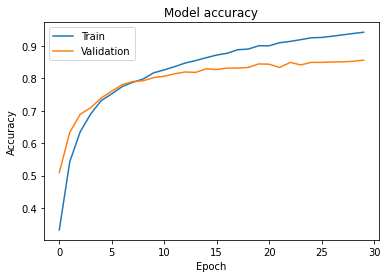

In [18]:
# Plot training & validation accuracy values
plt.plot(history_max_avg_pooling_v5.history['accuracy'])
plt.plot(history_max_avg_pooling_v5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# consider taking into account the weights of the classes
# consider 'early stopping'


In [ ]:
bert_preprocess_v4 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model_v4 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [ ]:
# Define input layer
input_text_v4 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   # define an input tensor --> the input data to the model will be a string of variable length

# Preprocess input text
text_preprocessed_v4 = bert_preprocess_v4(input_text_v4)                           # This layer converts the input string into a format that can be understood by the BERT model

# Encode input text with BERT
output_bert_v4 = bert_model_v4(text_preprocessed_v4)                               # This layer encodes the input text using the BERT model and returns the encoded outputs
                                                                                # After that, this will be fed into the neural network layers.

# Get sequence output
sequence_output_v4 = output_bert_v4['sequence_output']

# Apply max pooling over sequence output
max_pooling_v4 = tf.keras.layers.GlobalMaxPooling1D()(sequence_output_v4)

# Apply average pooling over sequence output
avg_pooling_v4 = tf.keras.layers.GlobalAveragePooling1D()(sequence_output_v4)

# Concatenate max pooled output and pooled output
concatenated_v4 = tf.keras.layers.Concatenate()([max_pooling_v4, avg_pooling_v4, output_bert_v4['pooled_output']])

# Apply dense layers to concatenated output
dense_1_v4 = tf.keras.layers.Dense(512, activation='relu')(concatenated_v4)
dense_2_v4 = tf.keras.layers.Dense(256, activation='relu')(dense_1_v4)
dense_3_v4 = tf.keras.layers.Dropout(0.1)(dense_2_v4)
dense_4_v4 = tf.keras.layers.Dense(128, activation='relu')(dense_3_v4)
dense_5_v4 = tf.keras.layers.Dropout(0.1)(dense_4_v4)

# Define output layer
output_v4 = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(dense_5_v4)

# Define the model
model_max_avg_pooling_v4 = tf.keras.Model(inputs=input_text_v4, outputs=output_v4)

# Freeze the BERT layers
bert_model_v4.trainable = False

# Compile the model
optimizer_v4 = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_max_avg_pooling_v4.compile(optimizer=optimizer_v4, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainfeatures, trainlabels)).batch(32) # create a TensorFlow dataset from the input data tensors, which are typically NumPy arrays or Pandas dataframes
val_dataset = tf.data.Dataset.from_tensor_slices((validfeatures, validlabels)).batch(32) 

In [ ]:
# history_max_avg_pooling_v3 = model_max_avg_pooling_v3.fit(train_dataset, epochs=30, class_weight=class_weights_dict, validation_data=val_dataset)

# compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=binarizer.classes_, y=trainlabels_original)

# create a dictionary of class weights
class_weights_dict = dict(enumerate(class_weights))

history_max_avg_pooling_v4 = model_max_avg_pooling_v4.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict)


Epoch 1/30
398/398 [==============================] - 95s 218ms/step - loss: 2.1184 - accuracy: 0.3146 - val_loss: 1.6025 - val_accuracy: 0.5138
Epoch 2/30
398/398 [==============================] - 81s 202ms/step - loss: 1.4506 - accuracy: 0.5385 - val_loss: 1.1924 - val_accuracy: 0.6369
Epoch 3/30
398/398 [==============================] - 79s 198ms/step - loss: 1.1436 - accuracy: 0.6422 - val_loss: 0.9988 - val_accuracy: 0.6878
Epoch 4/30
398/398 [==============================] - 79s 198ms/step - loss: 0.9741 - accuracy: 0.6933 - val_loss: 0.8825 - val_accuracy: 0.7189
Epoch 5/30
398/398 [==============================] - 79s 198ms/step - loss: 0.8776 - accuracy: 0.7256 - val_loss: 0.8062 - val_accuracy: 0.7421
Epoch 6/30
398/398 [==============================] - 79s 198ms/step - loss: 0.7889 - accuracy: 0.7542 - val_loss: 0.7335 - val_accuracy: 0.7648
Epoch 7/30
398/398 [==============================] - 79s 198ms/step - loss: 0.7237 - accuracy: 0.7781 - val_loss: 0.7068 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_max_avg_pooling_v3.history['accuracy'])
plt.plot(history_max_avg_pooling_v3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



---



# Notes

*   서빙:

    *   데이터를 받으면 ML 모델의 predict 함수를 부른 다음에 그 결과값을 반환하는 일련의 행위 자체를, 사용자가 직접 코드를 돌려보는게 아니라 서버에서 API 형태로 제공하는 서비스
    *   이를 위해서는, 그러한 모델이 (혹은 API 서버가) OS 라던지 특정 Python 패키지에 의존성이 없도록 container 나 VM 기반으로 패키징 되어있어야됨 → __모델 패키징__
          *    기본적인 Rest API 서빙 framework: *Docker*, *Flask*, *FastAPI*
          *    ML 모델에 특화된 API 서빙 framework: BentoML, *Kubeflow*, TFServing, seldon-core

    *   서빙 후에도 환경이 제대로 돌아가고 있는지, model의 성능이 떨어지고 있지 않는지와 같은 metric 을 지속적으로 모니터링해야되고, 문제가 생기면 알람을 받고, 이러한 것들을 자동화해야됨 → 서빙 모니터링
          *    Prometheus, Grafana, Thanos 
    *   서빙 시, 모델의 성능이 떨어지면 예전 모델로 롤백 한다거나 A/B Testing을 한다거나 이러한 성능 확인을 위해서 이전 모델 학습과정 전체를 다시 돌려보고 싶은 경우가 생길 수 있는데 이를 위해서는 모델 개발 단계부터 단순한 파이썬 코드가 아니라 특정한 파이프라인 형태로 개발을 해야 재사용이 가능하고 재현이 가능함 → 파이프라인 매니징
          *   Kubeflow, argo workflows, Airflow






In [ ]:
# See this video for ModelDB (model management using Kubeflow)
# https://www.youtube.com/watch?v=6wWdNg0GMV4




---



In [ ]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

def intent_classification_bert():
  
  # Initializing the BERT layers
  input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # define an input tensor --> the input data to the model will be a string of variable length
  text_preprocessed = bert_preprocess(input_text) # This layer converts the input string into a format that can be understood by the BERT model
  output_bert = bert_model(text_preprocessed) # This layer encodes the input text using the BERT model and returns the encoded outputs
                                              # After that, this will be fed into the neural network layers.

  # Initializing the neural network layers
  encoded_text = output_bert['pooled_output']
  layer_1 = tf.keras.layers.Dense(512, activation='relu')(encoded_text)
  layer_2 = tf.keras.layers.Dense(256, activation='relu')(layer_1)
  layer_3 = tf.keras.layers.Dense(128, activation='relu')(layer_2)
  layer_4 = tf.keras.layers.Dropout(0.1)(layer_3) # This layer will be used to prevent model overfitting
                                                                                 # We will use 0.1% of the neurons to handle overfitting
  output = tf.keras.layers.Dense(trainlabels.shape[1], activation='softmax')(layer_4)  # It only has one neuron. We also initialize the activation function as sigmoid. 
                                                                                 # sigmoid is used when we have output values that between 0 and 1. 
                                                                                 # In our case, when making predictions, 
                                                                                 # the prediction probability will lie between 0 and 1. That’s why it is best suited.
                                                                                 # We also name the layer as output because this is our output layer.
  return tf.keras.Model(input_text, output)

In [ ]:
classifier_model = intent_classification_bert()

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) # Since this is a non-binary classification problem and the model outputs probabilities, 
                                                                 # you’ll use losses.CategoricalCrossentropy loss function.
metrics = tf.metrics.CategoricalAccuracy()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
epochs=20
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(x=trainfeatures, y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               #class_weight=class_weights_dict,
                               epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


398/398 [==============================] - ETA: 0s - loss: 2.5312 - categorical_accuracy: 0.1350

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


398/398 [==============================] - 99s 219ms/step - loss: 2.5312 - categorical_accuracy: 0.1350 - val_loss: 2.4293 - val_categorical_accuracy: 0.2220
Epoch 2/20
398/398 [==============================] - 87s 218ms/step - loss: 2.3493 - categorical_accuracy: 0.2544 - val_loss: 2.2450 - val_categorical_accuracy: 0.3194
Epoch 3/20
398/398 [==============================] - 86s 217ms/step - loss: 2.1798 - categorical_accuracy: 0.3273 - val_loss: 2.0829 - val_categorical_accuracy: 0.3728
Epoch 4/20
398/398 [==============================] - 82s 206ms/step - loss: 2.0371 - categorical_accuracy: 0.3653 - val_loss: 1.9543 - val_categorical_accuracy: 0.4130
Epoch 5/20
398/398 [==============================] - 87s 218ms/step - loss: 1.9231 - categorical_accuracy: 0.4022 - val_loss: 1.8528 - val_categorical_accuracy: 0.4400
Epoch 6/20
398/398 [==============================] - 86s 217ms/step - loss: 1.8315 - categorical_accuracy: 0.4286 - val_loss: 1.7696 - val_categorical_accuracy: 0.46